# Sentiment analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import nltk
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax
from sentence_transformers import SentenceTransformer, util
from scipy.interpolate import interp1d

sns.set(style="darkgrid")

nltk.download('punkt')

c:\Users\Mathieu\anaconda3\envs\ada_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score

In [3]:
DATA_PATH = "../../../data/final_dataset.pkl"
df_extended = pd.read_pickle(DATA_PATH)#[["Wikipedia_movie_ID", "summary", "category"]]
df_extended.dropna(subset=["summary"], inplace=True)
df_extended.sample(3)

Wikipedia_movie_ID                                            summary  \
3961             1365472  Self-destructive, alcoholic nymphomaniac Maryl...   
2175              643850  Lieutenant Commander Thomas Dodge , a capable ...   
9681             3957197  Rocky Mulloy was sentenced to life in prison f...   

     Freebase_movie_ID           Movie_name  Movie_release_date  \
3961         /m/04x0b4  Written on the Wind                 NaN   
2175         /m/02zzbh       Down Periscope              1996.0   
9681         /m/0b8ljd           Cry Danger              1951.0   

                  Movie_box_office_revenue  Movie_runtime   Movie_languages  \
3961  $4.3 million (North America rentals)           95.0  English Language   
2175                            37553752.0           92.0  English Language   
9681                                   NaN          123.0  English Language   

               Movie_countries  \
3961  United States of America   
2175  United States of America   
9681  United States of America   

                                           Movie_genres           category  \
3961  Romantic drama, Romance Film, Family Drama, Dr...   [Drama, Romance]   
2175                                  Comedy, Slapstick           [Comedy]   
9681         Thriller, Crime Thriller, Drama, Film noir  [Drama, Thriller]   

          continent  Rating  
3961  North America     7.3  
2175  North America     6.2  
9681  North America     7.3

### Version of sentiment analysis using emotions and segments

In [7]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [8]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed
threshold = 0.5

#iterate over summaries
for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    embeddings = sentence_model.encode(sentences, convert_to_tensor=True)

    # Segment the text based on cosine similarity
    segments = []
    current_segment = [sentences[0]]

    for i in range(len(sentences) - 1):
        similarity = util.pytorch_cos_sim(embeddings[i], embeddings[i + 1]).item()

        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []

        current_segment.append(sentences[i + 1])

    #final segment join
    segments.append(" ".join(current_segment))

    # Classify the segments for emotions
    out = classifier(segments)
    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['segment_id'] = [i for i in range(len(segments))]
    emotions['segment'] = [segments[i] for i in range(len(segments))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions)
    
    big_df = pd.concat([big_df, emotions], ignore_index=True)

print(big_df.shape)

c:\Users\Mathieu\anaconda3\envs\ada_2\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2/2 [00:06<00:00,  3.29s/it]

(49, 10)


### Version of sentiment analysis using sentences and emotions

In [9]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)

    out = classifier(sentences)

    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['sentence_id'] = [i for i in range(len(sentences))]
    emotions['sentence'] = [sentences[i] for i in range(len(sentences))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

    big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

c:\Users\Mathieu\anaconda3\envs\ada_2\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

(57, 10)


### Version of sentiment analysis using positive/negative only

In [10]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

big_df = pd.DataFrame()

limit = 10 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    for idx_s, s in enumerate(sentences):
        t_encoded = tokenizer(s, return_tensors='pt')
        t_output = model(**t_encoded)
        scores = softmax(t_output.logits.detach().numpy(), axis=1)
        
        emotions = pd.DataFrame(scores, columns=[dict_labels[i] for i in range(3)])
        emotions['sentence_id'] = idx_s
        emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

        big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:36<00:00,  3.68s/it]

(304, 5)


In [11]:
big_df.head(20)

negative   neutral  positive  sentence_id  Wikipedia_movie_ID
0   0.007669  0.810829  0.181502            0                 330
1   0.015329  0.948648  0.036023            0                3333
2   0.004450  0.908020  0.087529            1                3333
3   0.010366  0.701469  0.288165            2                3333
4   0.116897  0.831204  0.051899            3                3333
5   0.497701  0.490280  0.012019            4                3333
6   0.412974  0.556182  0.030844            5                3333
7   0.784632  0.209100  0.006268            6                3333
8   0.168657  0.782348  0.048995            7                3333
9   0.005097  0.932409  0.062494            8                3333
10  0.840417  0.154061  0.005522            9                3333
11  0.007863  0.895003  0.097134           10                3333
12  0.017188  0.824433  0.158379           11                3333
13  0.603445  0.380301  0.016254           12                3333
14  0.583961  0.403707  0.012331           13                3333
15  0.013346  0.930017  0.056636           14                3333
16  0.028177  0.892003  0.079820           15                3333
17  0.013310  0.948935  0.037755           16                3333
18  0.460375  0.515785  0.023840           17                3333
19  0.366025  0.611801  0.022175           18                3333

# Analyzing results

In [15]:
df_emotions

anger   disgust      fear       joy   neutral   sadness  surprise  \
0       0.009699  0.014965  0.018099  0.162633  0.744054  0.008015  0.042536   
1       0.008854  0.029581  0.002972  0.115284  0.753907  0.025629  0.063773   
2       0.006815  0.012304  0.002509  0.400154  0.525703  0.021161  0.031356   
3       0.007186  0.063207  0.006138  0.362792  0.464898  0.077416  0.018363   
4       0.022412  0.071887  0.036786  0.049055  0.807039  0.005008  0.007814   
...          ...       ...       ...       ...       ...       ...       ...   
746020  0.005617  0.009072  0.001550  0.914918  0.044449  0.004787  0.019607   
746021  0.005512  0.006739  0.001492  0.510576  0.436107  0.005963  0.033612   
746022  0.064477  0.038561  0.052132  0.047033  0.497495  0.265098  0.035205   
746023  0.070431  0.643584  0.003790  0.007467  0.179304  0.093023  0.002401   
746024  0.072808  0.013691  0.012635  0.006192  0.048372  0.841441  0.004860   

        sentence_id                                           sentence  \
0                 0  In order to prepare herself to play a role com...   
1                 1  The film follows two juxtaposed families: the ...   
2                 1  The Stoneman brothers visit the Camerons at th...   
3                 1  The elder of the two Stoneman sons falls in lo...   
4                 1  When the Civil War begins, all the young men j...   
...             ...                                                ...   
746020        42716  When Clover's ' childhood friend, Cherries ', ...   
746021        42716  It isn't long before their rekindled friendshi...   
746022        42716  But as time passes and passions fade, the coup...   
746023        42717  Two adolescent children of wealthy parents dea...   
746024        42717  Friends John  and Alex  deal with issues of be...   

        Wikipedia_movie_ID  
0                      330  
1                     3333  
2                     3333  
3                     3333  
4                     3333  
...                    ...  
746020            37492363  
746021            37492363  
746022            37492363  
746023            37501922  
746024            37501922  

[746025 rows x 10 columns]

In [23]:
# Define the paths to the data files
DATA_PATH = "../../../data/emotions_interpolated_20.pkl"  # Path to the CSV file containing sentence emotions data
DATA_PATH_MOVIE_METADATA = "../../../data/final_dataset.pkl"  # Path to the pickle file containing movie metadata

df_emotions = pd.read_pickle(DATA_PATH)

with open(DATA_PATH_MOVIE_METADATA, 'rb') as f:
    df_metadata = pickle.load(f)

df_metadata.sample(3)

Wikipedia_movie_ID                                            summary  \
8273              3235051  The film is set in Great Britain and Ireland, ...   
27026            18764211  Buck and the Preacher opens with deep rhythm a...   
27164            18885034  The character-driven story of Pool of London c...   

      Freebase_movie_ID             Movie_name  Movie_release_date  \
8273          /m/0907zk       Tristan & Isolde              2006.0   
27026        /m/04gp0s9  Buck and the Preacher                 NaN   
27164        /m/04jmbj_         Pool of London              1951.0   

                    Movie_box_office_revenue  Movie_runtime   Movie_languages  \
8273                              28047963.0          125.0  English Language   
27026                                    NaN          102.0  English Language   
27164  £130,000 or $392,000 (UK)$40,000 (US)           85.0               NaN   

                                         Movie_countries  \
8273   United States of America, Czech Republic, Unit...   
27026                           United States of America   
27164                                     United Kingdom   

                                            Movie_genres  \
8273   Tragedy, Adventure, Period piece, Drama, Roman...   
27026  Action/Adventure, Revisionist Western, Western...   
27164                  Crime Fiction, Drama, Crime Drama   

                                 category      continent  Rating  
8273   [Action/Adventure, Drama, Romance]  North America     5.9  
27026          [Action/Adventure, Comedy]  North America     6.6  
27164                   [Drama, Thriller]         Europe     7.1

In [24]:
target_timesteps = 20  # Number of timesteps to which we want to interpolate the data
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"] 

def interpolate_emotions(movie_data, target_timesteps):
    """
    Interpolates emotion values over a fixed number of timesteps for a given movie data.

    This function takes a DataFrame containing emotion values over time for a specific movie
    and interpolates each emotion to fit a fixed number of timesteps. This is useful for standardizing
    the data across movies with different numbers of timestamps, allowing for easier comparison.

    Args:
        movie_data (pd.DataFrame): A DataFrame containing emotion values for a specific movie.
            Each row represents a timestep, and columns should include:
            - "Wikipedia_movie_ID" (int or str): The unique identifier for the movie.
            - One column per emotion (e.g., "anger", "disgust", "fear", etc.).
        target_timesteps (int): The target number of timesteps for interpolation. The function
            will output a DataFrame with this fixed number of rows.

    Returns:
        pd.DataFrame: A DataFrame with `target_timesteps` rows, containing the interpolated
        emotion values. Columns include:
            - "Wikipedia_movie_ID" (int or str): Repeated ID of the movie for each row.
            - One column per emotion (e.g., "anger", "disgust", "fear", etc.) with interpolated values.
            
    Notes:
        - This function uses linear interpolation. For other types of interpolation,
          change the `kind` parameter in `interp1d`.
        - The function extrapolates values if the target positions extend beyond the range
          of `movie_data`.

    """
    # Define the original positions based on the length of the input data
    original_positions = np.arange(len(movie_data))
    # Define the target positions for interpolation based on the target timesteps
    target_positions = np.linspace(0, len(movie_data) - 1, target_timesteps)
    
    # Initialize a dictionary to store the interpolated data
    interpolated_data = {emotion: [] for emotion in emotions}
    # Add the Wikipedia_movie_ID to the dictionary, repeating it for each target timestep
    interpolated_data["Wikipedia_movie_ID"] = [movie_data["Wikipedia_movie_ID"].iloc[0]] * target_timesteps
    
    # Interpolate each emotion's values over the target positions
    for emotion in emotions:
        # Create a linear interpolation function for the current emotion
        interp_function = interp1d(original_positions, movie_data[emotion], kind="linear", fill_value="extrapolate")
        interpolated_data[emotion] = interp_function(target_positions)

    return pd.DataFrame(interpolated_data)

In [25]:
import tqdm
interpolated_movies = []

for movie_id, movie_data in tqdm.tqdm(df_emotions.groupby("Wikipedia_movie_ID")):
    # Apply the interpolate_emotions function to get a fixed number of timesteps for this movie
    interpolated_movie = interpolate_emotions(movie_data, target_timesteps)
    interpolated_movies.append(interpolated_movie)

interpolated_df = pd.concat(interpolated_movies, ignore_index=True)

# Add a timestep column to indicate the timestep index within each movie
interpolated_df['timestep'] = interpolated_df.groupby("Wikipedia_movie_ID").cumcount()
interpolated_df_wo_NA = interpolated_df.merge(df_metadata[['Wikipedia_movie_ID', 'continent']], on='Wikipedia_movie_ID')
#interpolated_df_wo_NA = interpolated_df_wo_NA[interpolated_df_wo_NA['continent'] != 'North America']
interpolated_df_wo_NA = interpolated_df_wo_NA[~interpolated_df_wo_NA['continent'].isin(['Europe', 'North America'])]

100%|██████████| 34342/34342 [02:21<00:00, 243.48it/s]


In [26]:
# The NaN are due to the extrapolation on single sentence summaries (we should get rif of them and scrape)
interpolated_df.isna().sum()

anger                 0
disgust               0
fear                  0
joy                   0
neutral               0
sadness               0
surprise              0
Wikipedia_movie_ID    0
timestep              0
dtype: int64

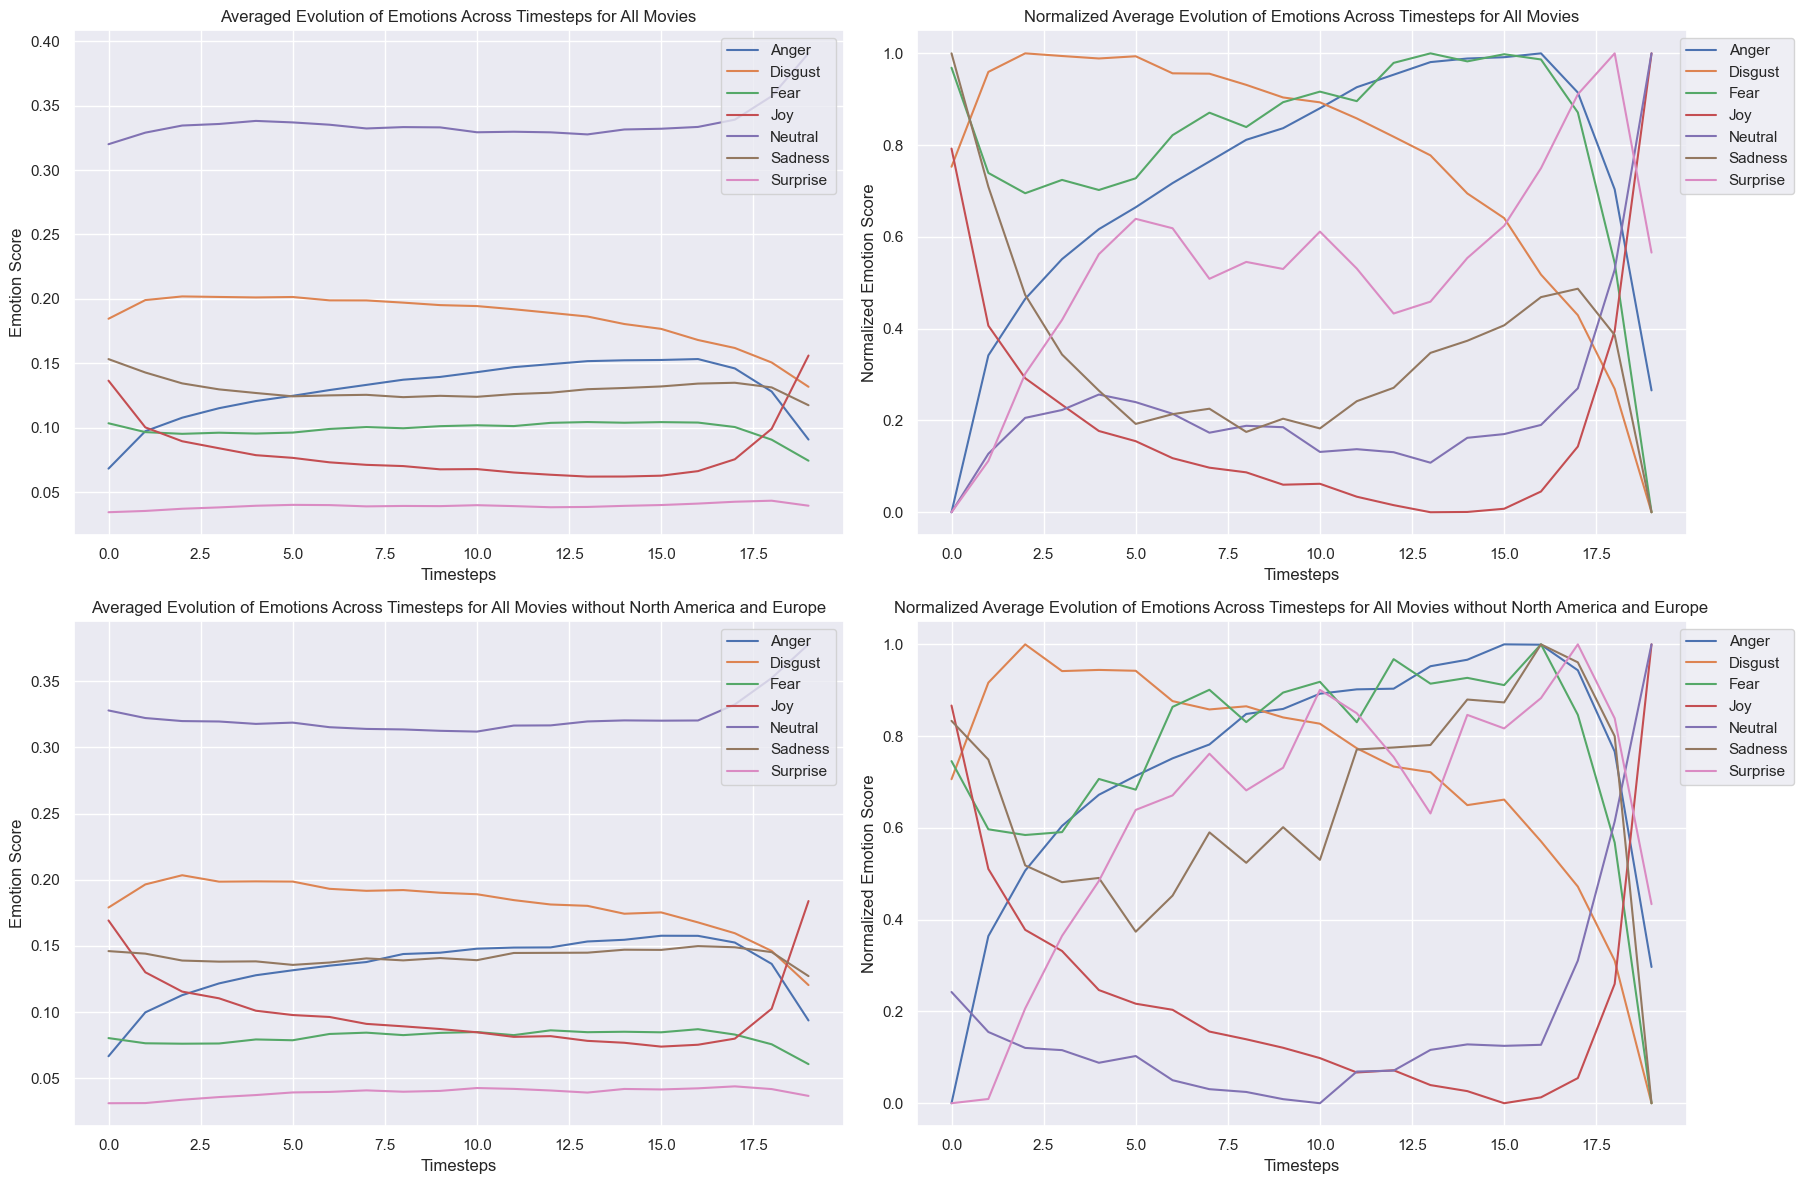

In [27]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
avg_emotions = interpolated_df.groupby("timestep")[emotions].mean()
avg_emotions_wo_america = interpolated_df_wo_NA.groupby("timestep")[emotions].mean()

#avg_emotions = avg_emotions[:target_timesteps]

#MinMax Normalization
normalized_emotions = avg_emotions.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
normalized_emotions_wo_america = avg_emotions_wo_america.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

#ZScore Normalization
fig, axes = plt.subplots(2, 2,figsize=(18, 12))
axes = axes.ravel()
for emotion in emotions:
    axes[0].plot(range(target_timesteps), avg_emotions[emotion], label=emotion.capitalize())
    axes[1].plot(range(target_timesteps), normalized_emotions[emotion], label=emotion.capitalize())
    axes[2].plot(range(target_timesteps), avg_emotions_wo_america[emotion], label=emotion.capitalize())
    axes[3].plot(range(target_timesteps), normalized_emotions_wo_america[emotion], label=emotion.capitalize())
axes[0].set_title("Averaged Evolution of Emotions Across Timesteps for All Movies")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Emotion Score")
axes[0].legend(loc="best")
axes[1].set_title("Normalized Average Evolution of Emotions Across Timesteps for All Movies")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Normalized Emotion Score")
axes[1].legend(loc="upper right", bbox_to_anchor=(1.15, 1))
axes[2].set_title("Averaged Evolution of Emotions Across Timesteps for All Movies without North America and Europe")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Emotion Score")
axes[2].legend(loc="best")
axes[3].set_title("Normalized Average Evolution of Emotions Across Timesteps for All Movies without North America and Europe")
axes[3].set_xlabel("Timesteps")
axes[3].set_ylabel("Normalized Emotion Score")
axes[3].legend(loc="best", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Now we can try for movies in already formed genres

In [28]:
df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID", "category"]], on="Wikipedia_movie_ID")
# create 1 row per movie per genre (so if a film is associated to 3 genres, it will have 3 rows)
df_exploded = df_exploded.explode("category")

df_exploded_wo_NA = df_exploded.merge(df_metadata[["Wikipedia_movie_ID", "continent"]], on="Wikipedia_movie_ID")
df_exploded_wo_NA = df_exploded_wo_NA[df_exploded_wo_NA['continent'] != 'North America'].drop('continent', axis=1).explode('category')
# Compute the mean of emotions per category and per timestep
df_grouped_by_genre = df_exploded.groupby(["category", "timestep"])[emotions].mean()
#df_grouped_by_genre
df_grouped_by_genre_wo_NA = df_exploded_wo_NA.groupby(["category", "timestep"])[emotions].mean()


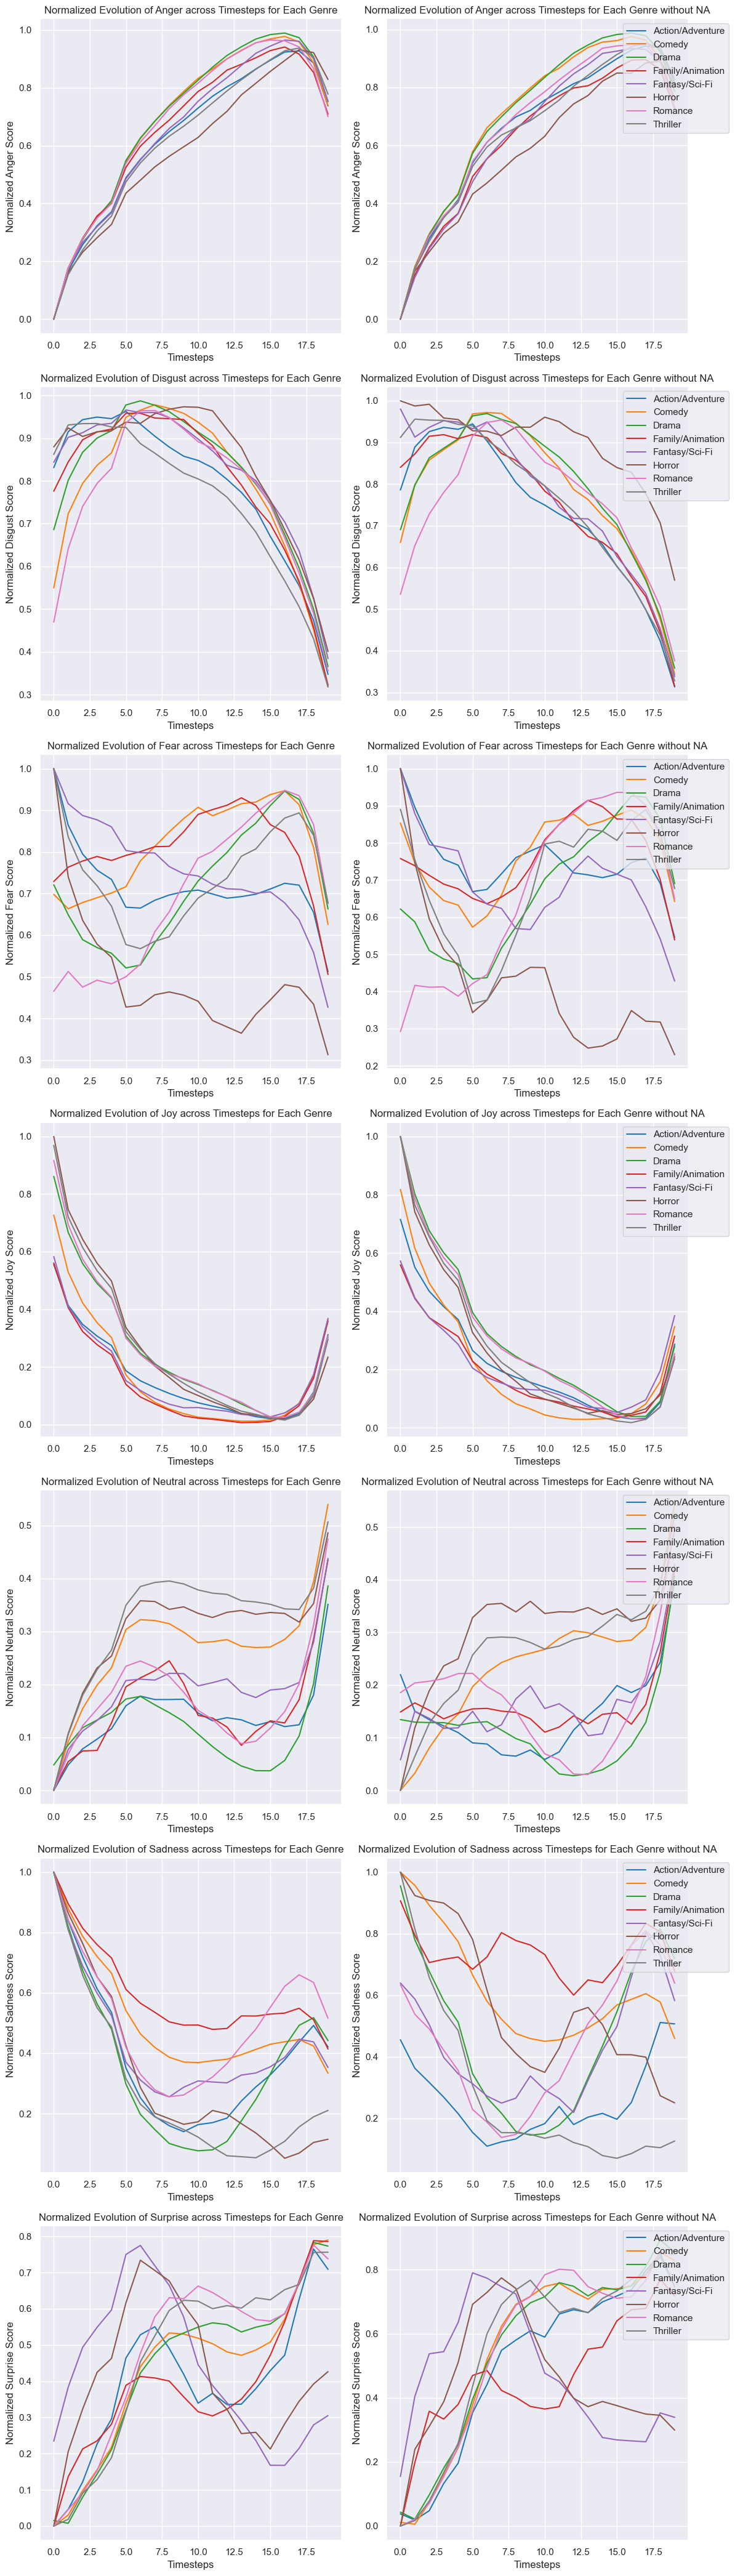

In [29]:
# Define a rolling window size for smoothing
window_size = 5
_, axes = plt.subplots(len(emotions), 2, figsize=(12, len(emotions)*6))
#axes = axes.ravel()
                       
for idx, emotion in enumerate(emotions):
    
    # Pivot the DataFrame to have genres as columns and timesteps as the index for the current emotion
    avg_emotion_by_genre = df_grouped_by_genre[emotion].unstack(level=0)
    avg_emotion_by_genre_wo_NA = df_grouped_by_genre_wo_NA[emotion].unstack(level=0)
                       
    # Normalize each genre's emotion scores across timesteps (min-max normalization)
    avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    avg_emotion_by_genre_wo_NA = avg_emotion_by_genre_wo_NA.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    # Apply rolling mean to smooth the emotion data over the defined window size
    smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
    smoothed_avg_emotion_by_genre_wo_NA = avg_emotion_by_genre_wo_NA.rolling(window=window_size, min_periods=1).mean()

    palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns)) 
    for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
        sns.lineplot(
            x=smoothed_avg_emotion_by_genre.index,
            y=smoothed_avg_emotion_by_genre[genre],
            ax=axes[idx, 0],
            color=palette[jdx]  
        )

        sns.lineplot(
            x=smoothed_avg_emotion_by_genre_wo_NA.index,
            y=smoothed_avg_emotion_by_genre_wo_NA[genre],
            ax=axes[idx, 1],
            label=genre,
            color=palette[jdx]  
        )
    
    axes[idx, 0].set_title(f"Normalized Evolution of {emotion.capitalize()} across Timesteps for Each Genre")
    axes[idx, 0].set_xlabel("Timesteps")
    axes[idx, 0].set_ylabel(f"Normalized {emotion.capitalize()} Score")
    
    
    axes[idx, 1].set_title(f"Normalized Evolution of {emotion.capitalize()} across Timesteps for Each Genre without NA")
    axes[idx, 1].set_xlabel("Timesteps")
    axes[idx, 1].set_ylabel(f"Normalized {emotion.capitalize()} Score")
    axes[idx, 1].legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    
plt.tight_layout()
plt.show()

In [30]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID", "category", "continent"]], on="Wikipedia_movie_ID")

# Explode the "category" column to separate rows if a movie has multiple categories
df_exploded = df_exploded.explode("category")
# Group by "continent", "category", and "timestep" to analyze emotions by continent and genre over time
df_groupy_by_continent = df_exploded.groupby(["continent", "category", "timestep"])[emotions].mean()

In [31]:
# Assign individual DataFrames to variables for each continent for easy access
africa_df =  df_groupy_by_continent.xs('Africa', level='continent')
asia_df = df_groupy_by_continent.xs('Asia', level='continent')
europe_df = df_groupy_by_continent.xs('Europe', level='continent')
na_df = df_groupy_by_continent.xs('North America', level='continent')
oceania_df = df_groupy_by_continent.xs('Oceania', level='continent')
sa_df = df_groupy_by_continent.xs('South America', level='continent')

# Create a list containing all the continent-specific DataFrames for convenience
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df]

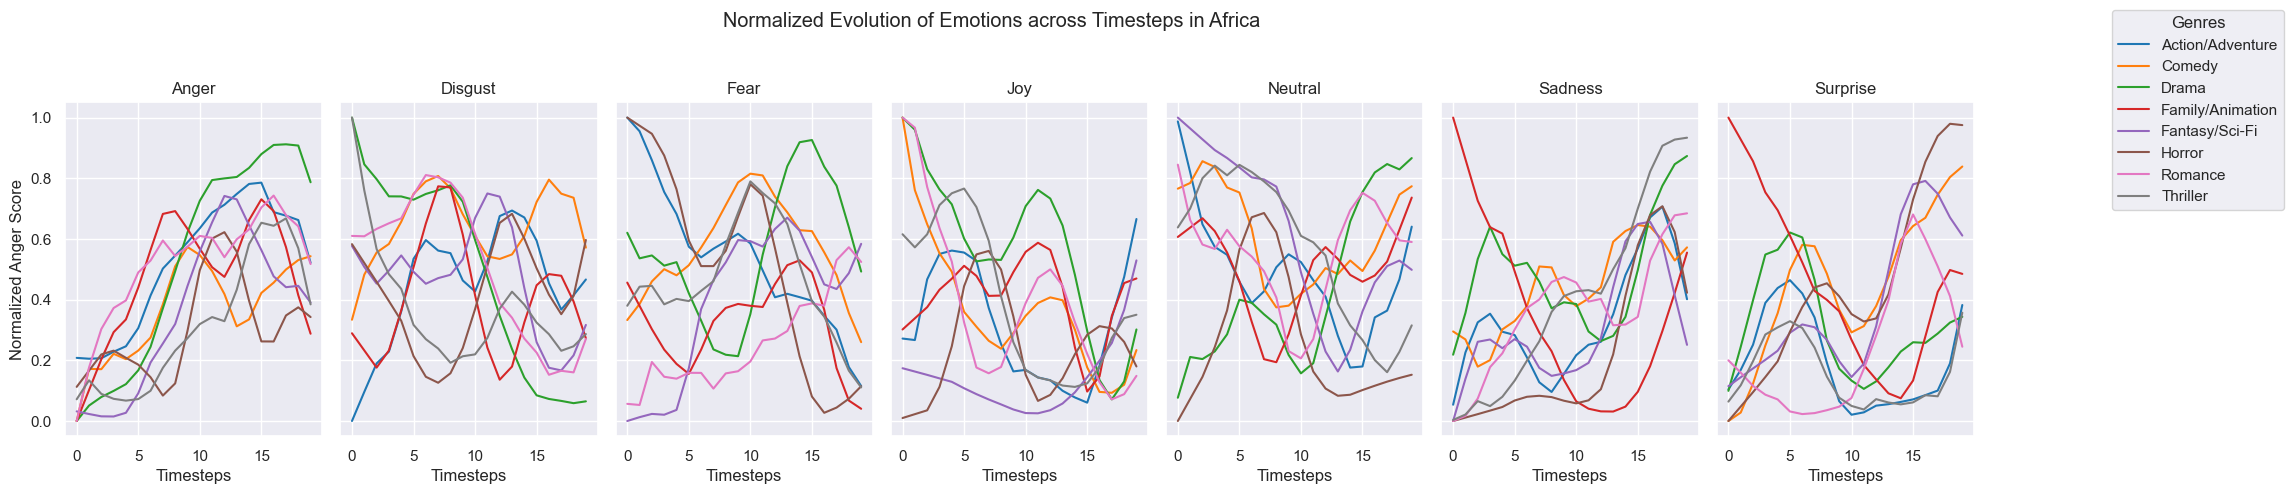

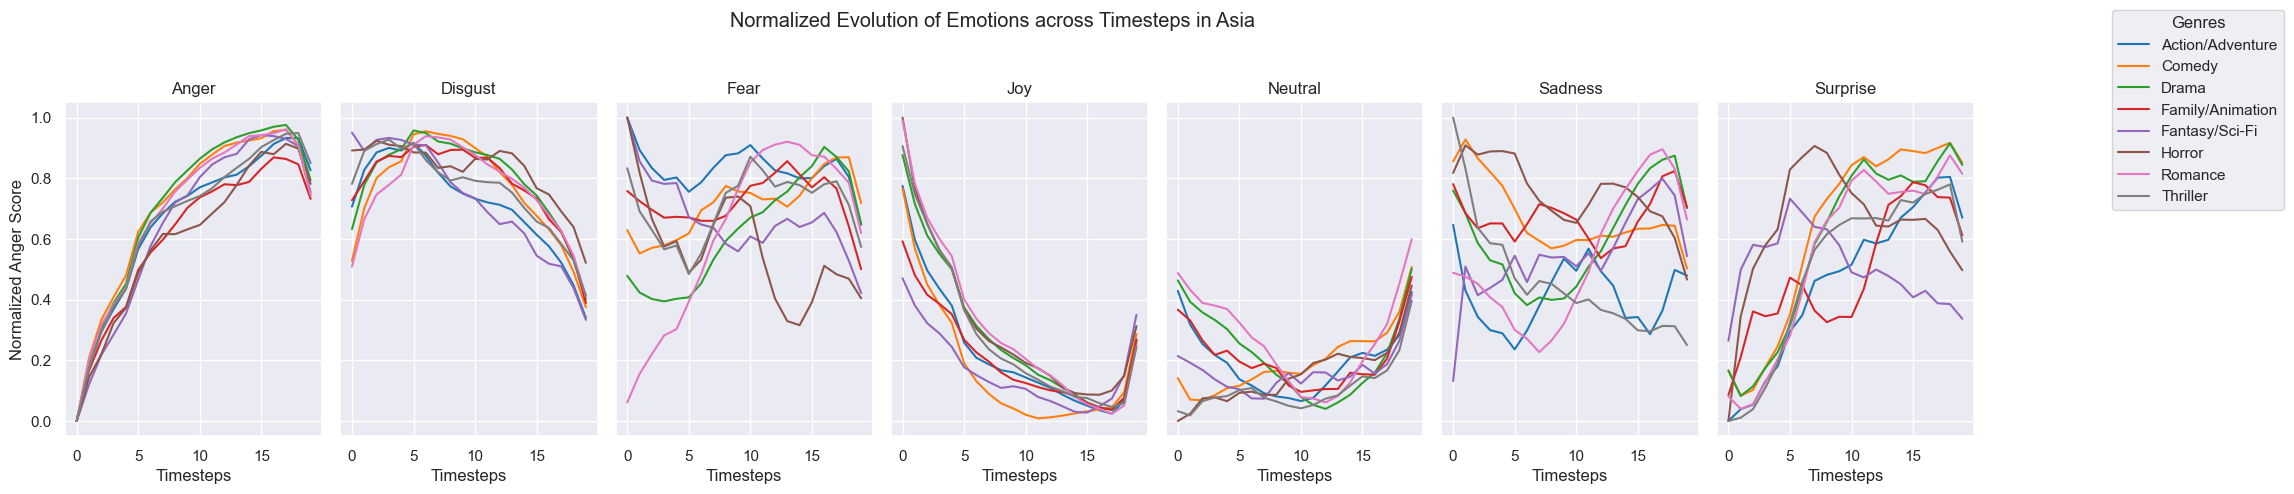

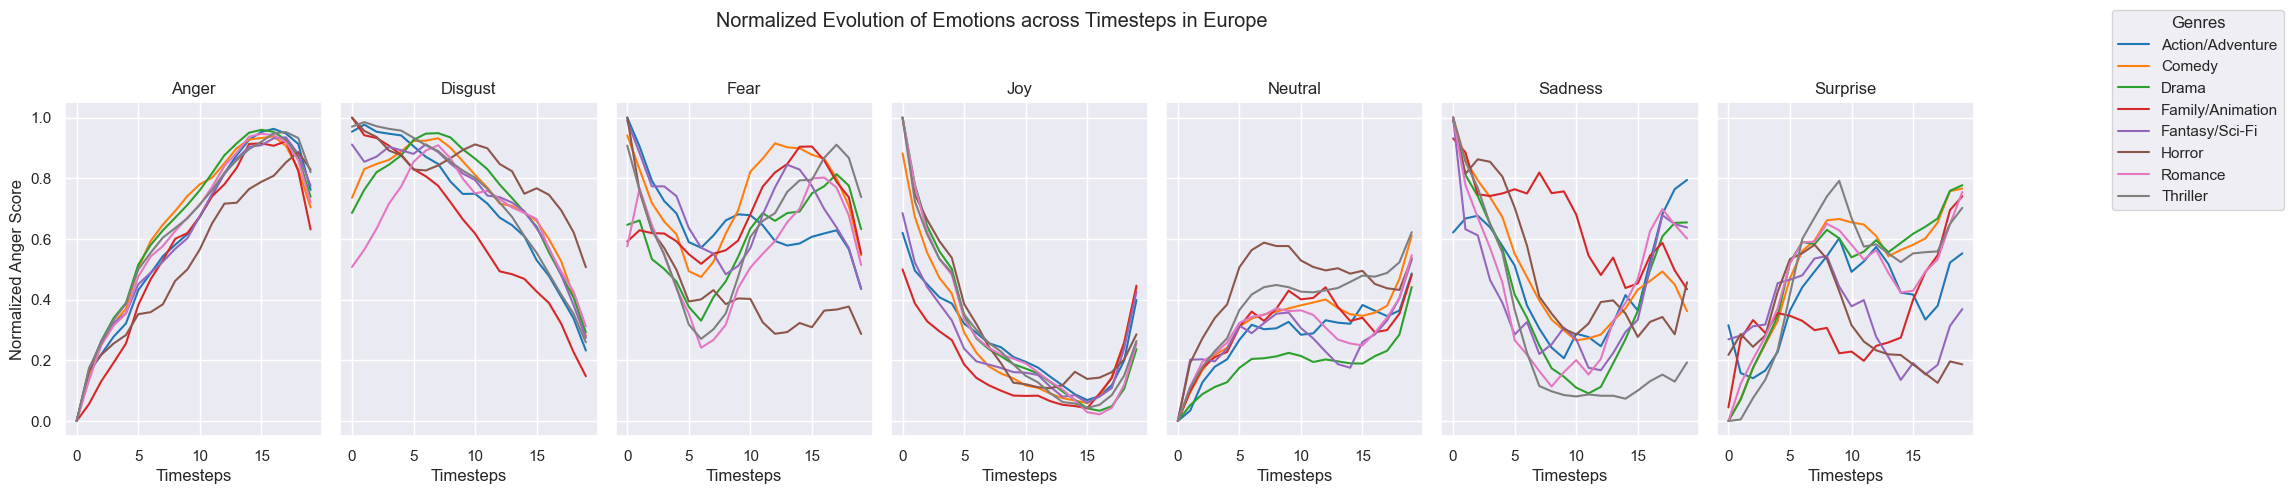

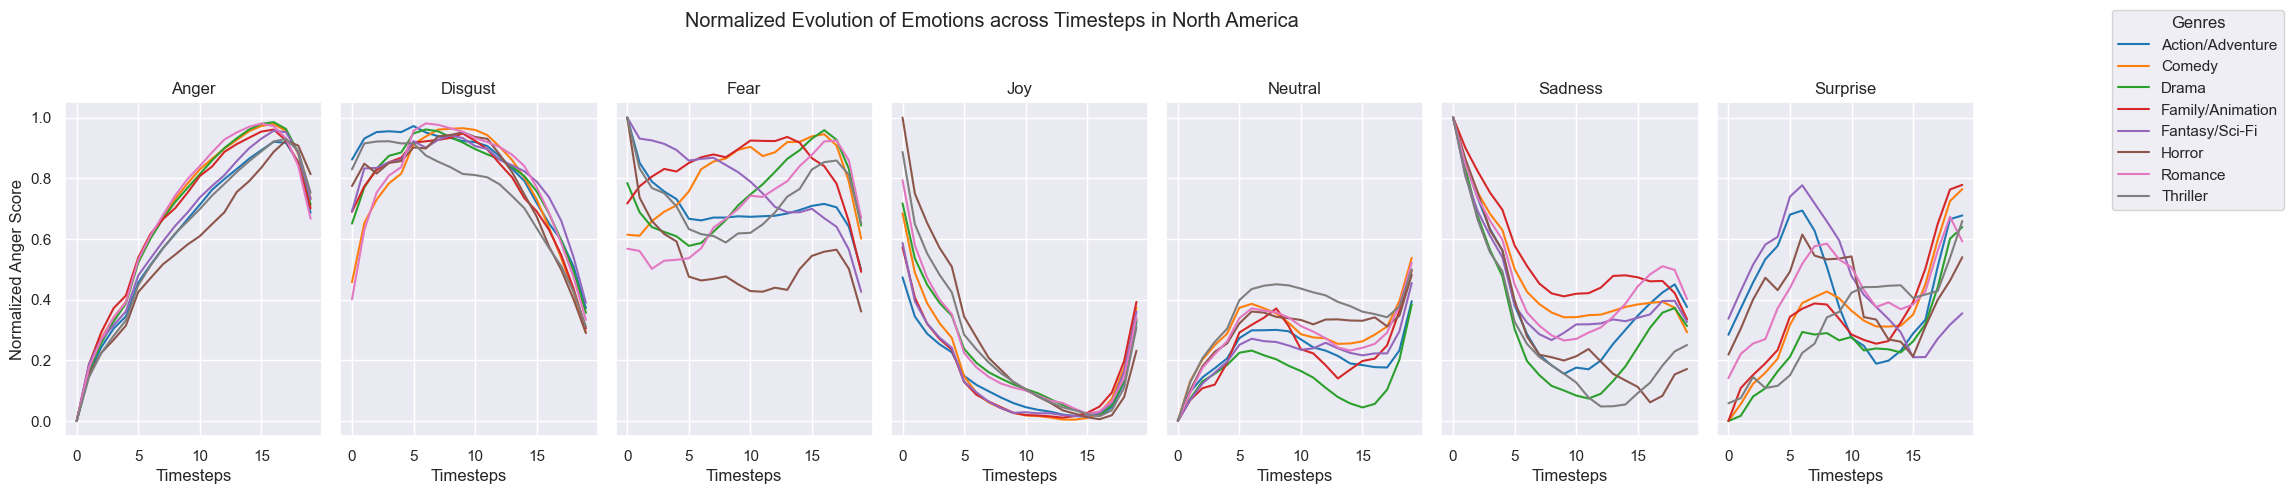

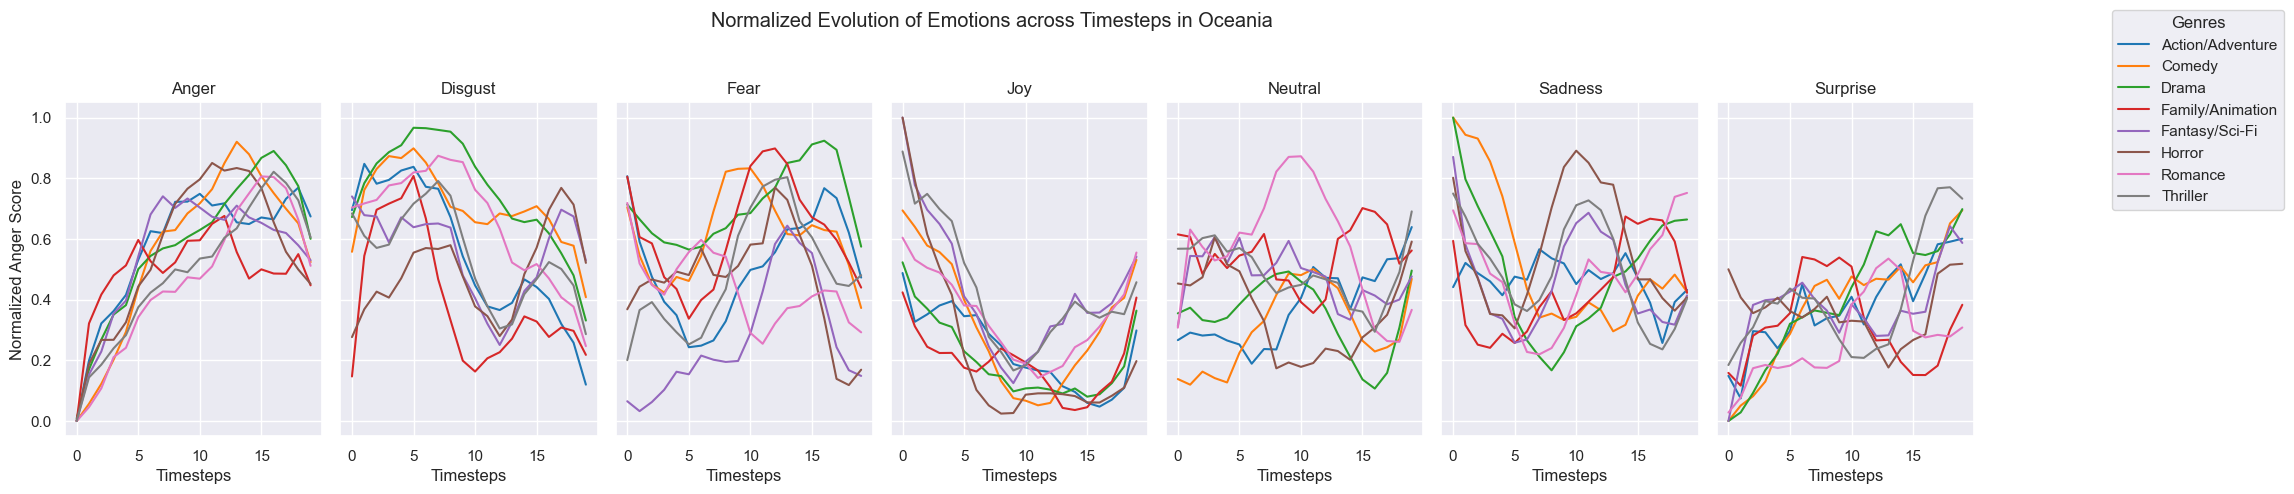

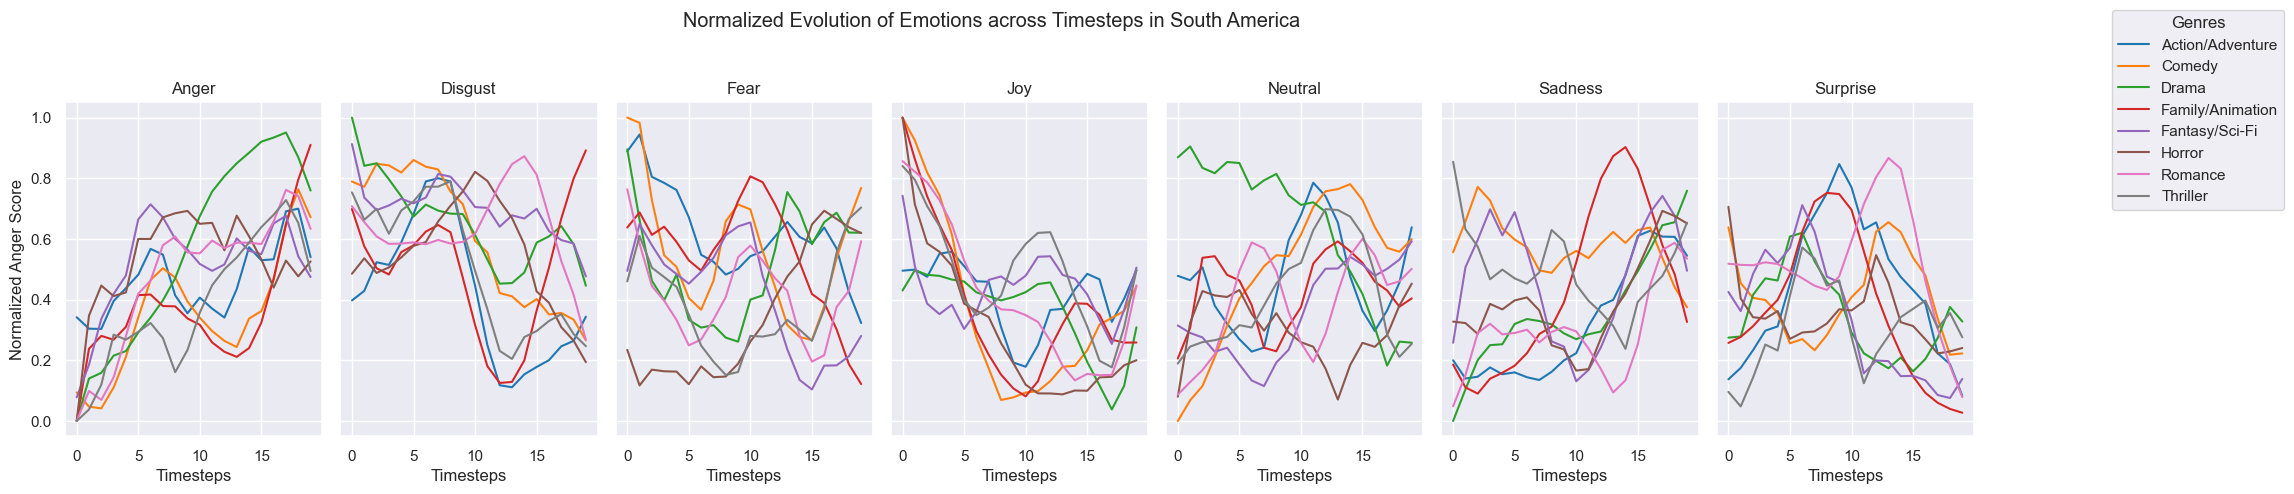

In [32]:

for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False

    for ax, emotion in zip(axes, emotions):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
        
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns)) 
        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

In [ ]:
a data[emotion].reset_index(drop=True)

AttributeError: 'float' object has no attribute 'min'

anger   disgust      fear       joy   neutral  \
category         timestep                                                     
Action/Adventure 0         0.090936  0.168748  0.145874  0.091344  0.339004   
                 1         0.121025  0.178103  0.124268  0.063263  0.357814   
                 2         0.129303  0.177781  0.121489  0.058828  0.362469   
                 3         0.136839  0.175590  0.121073  0.056165  0.364901   
                 4         0.138299  0.174111  0.119103  0.052938  0.371772   
...                             ...       ...       ...       ...       ...   
Thriller         15        0.180037  0.177329  0.140244  0.030192  0.319396   
                 16        0.185954  0.173432  0.135653  0.031541  0.320339   
                 17        0.175787  0.172351  0.135363  0.040741  0.318802   
                 18        0.155682  0.159037  0.127147  0.058308  0.337672   
                 19        0.107955  0.143506  0.103408  0.103920  0.384060   

                            sadness  surprise  
category         timestep                      
Action/Adventure 0         0.129378  0.034715  
                 1         0.119668  0.035859  
                 2         0.113150  0.036979  
                 3         0.107554  0.037877  
                 4         0.105970  0.037807  
...                             ...       ...  
Thriller         15        0.114634  0.038167  
                 16        0.113458  0.039624  
                 17        0.117939  0.039017  
                 18        0.120429  0.041725  
                 19        0.116221  0.040930  

[160 rows x 7 columns]

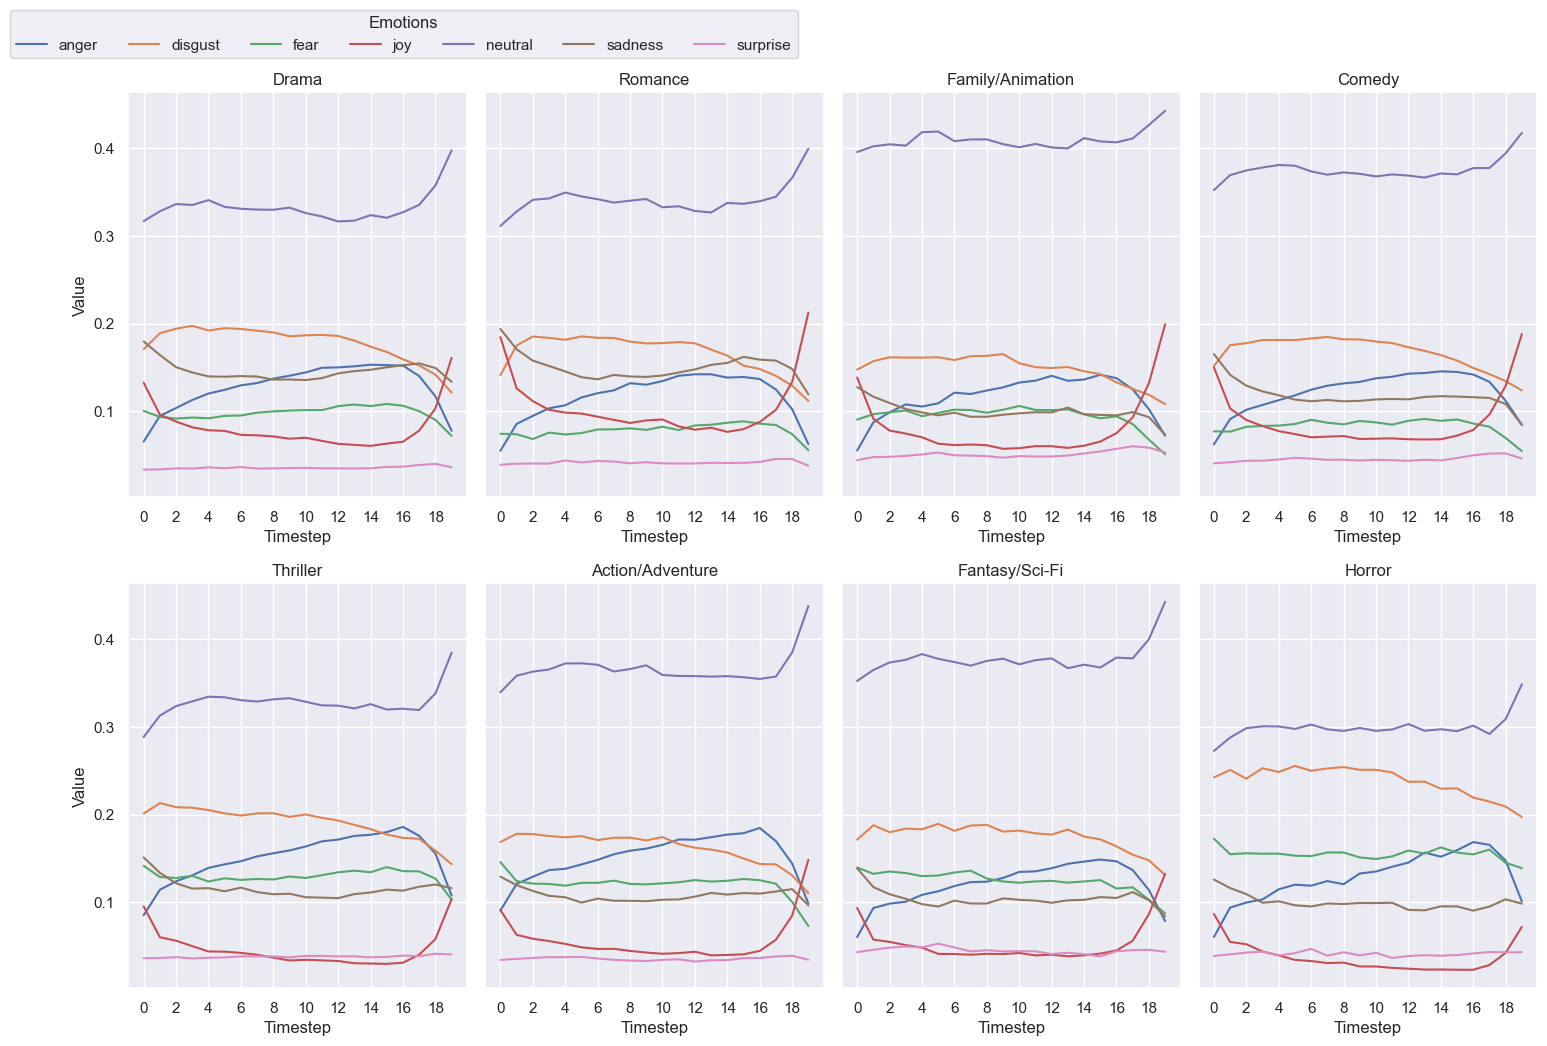

In [109]:
# Reset the index for easier manipulation
jsp = dfs[3].reset_index(level=1, drop=True)  # Assuming dfs[0] contains your data
categories = jsp.index.unique()  # Get the unique categories

# Create subplots: one plot per category
fig, axes = plt.subplots(2, len(categories) // 2, figsize=(15, 10), sharex=False, sharey=True)
axes = axes.flatten()

# Loop through each category and plot the emotions
for ax, category in zip(axes, ['Drama', 'Romance', 'Family/Animation', 'Comedy', 'Thriller', 'Action/Adventure', 'Fantasy/Sci-Fi', 'Horror']):
    data = jsp.loc[category]  # Get the data for the current category
    
    # Use sequential x-axis values if `data.index` is not numerical
    timesteps = range(len(data))
    
    # Iterate over emotions and plot each one
    for emotion in data.columns:
        emotion_value = data[emotion].reset_index(drop=True)
        #emotion_value = (emotion_value - emotion_value.min())/(emotion_value.max() - emotion_value.min())
        sns.lineplot(x=timesteps, y=emotion_value.reset_index(drop=True), label=emotion, ax=ax)
    
    ax.set_title(category)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value')
    
    # Set x-ticks for clarity
    if len(timesteps) > 10:  # If there are many timesteps, reduce the number of ticks
        ax.set_xticks(timesteps[::max(1, len(timesteps) // 10)])
    else:
        ax.set_xticks(timesteps)
    ax.tick_params(axis='x')  # Rotate labels for readability
     # Get the handles and labels from the last plot
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

# Remove legends from all subplots
for ax in axes:
    ax.legend_.remove()

# Add a single legend to the entire figure
fig.legend(handles, labels, loc='right', bbox_to_anchor=(0.5, 1.02), ncol=7, title="Emotions")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


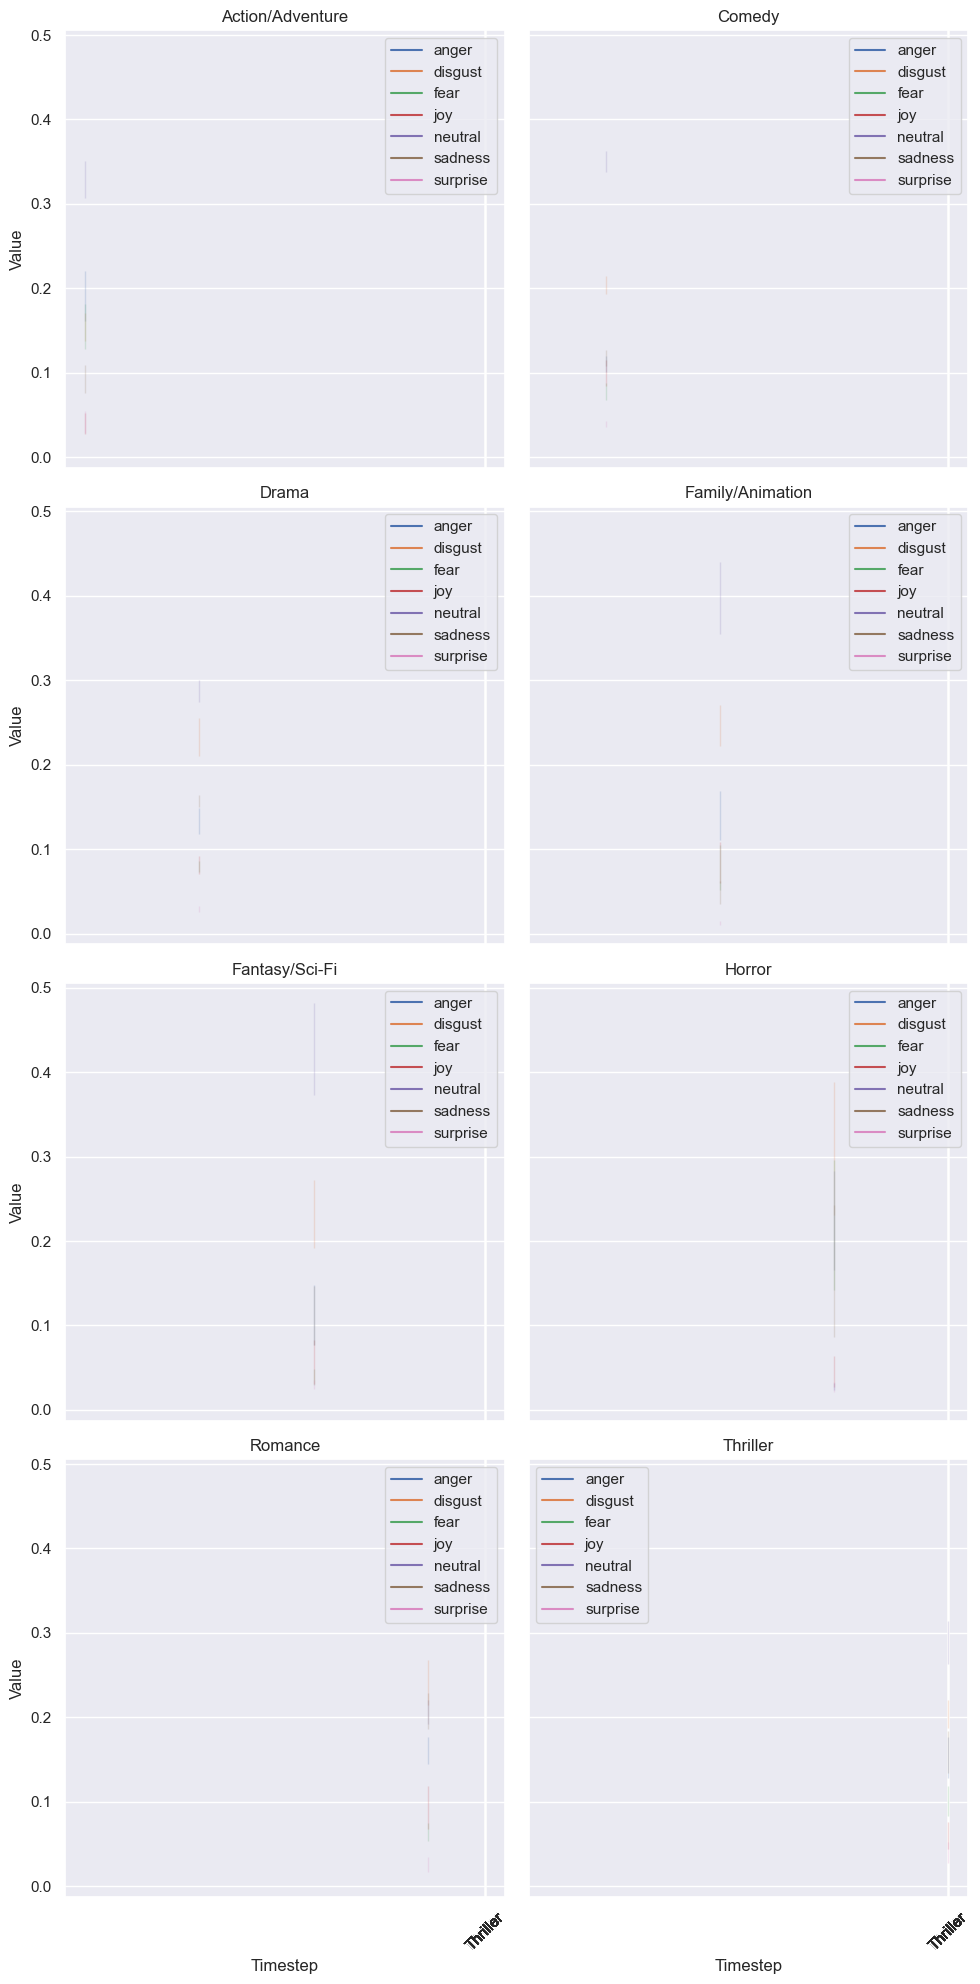

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index for easier manipulation
jsp = dfs[0].reset_index(level=1, drop=True)  # Assuming dfs[0] contains your data
categories = jsp.index.unique()  # Get the unique categories

# Create subplots: one plot per category
fig, axes = plt.subplots(len(categories)//2, 2, figsize=(10, 20), sharex=True, sharey=True)
axes = axes.flatten()
# Loop through each category and plot the emotions
for ax, category in zip(axes, categories):
    data = jsp.loc[category]  # Get the data for the current category
    
    # Iterate over emotions and plot each one
    for emotion in data.columns:
        sns.lineplot(x=data.index, y=data[emotion].reset_index(drop=True), label=emotion, ax=ax)
    
    ax.set_title(category)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value')
    ax.set_xticks(data.index)
    ax.tick_params(axis='x', rotation=45) 
# Adjust layout and show the plot

plt.tight_layout()
plt.show()


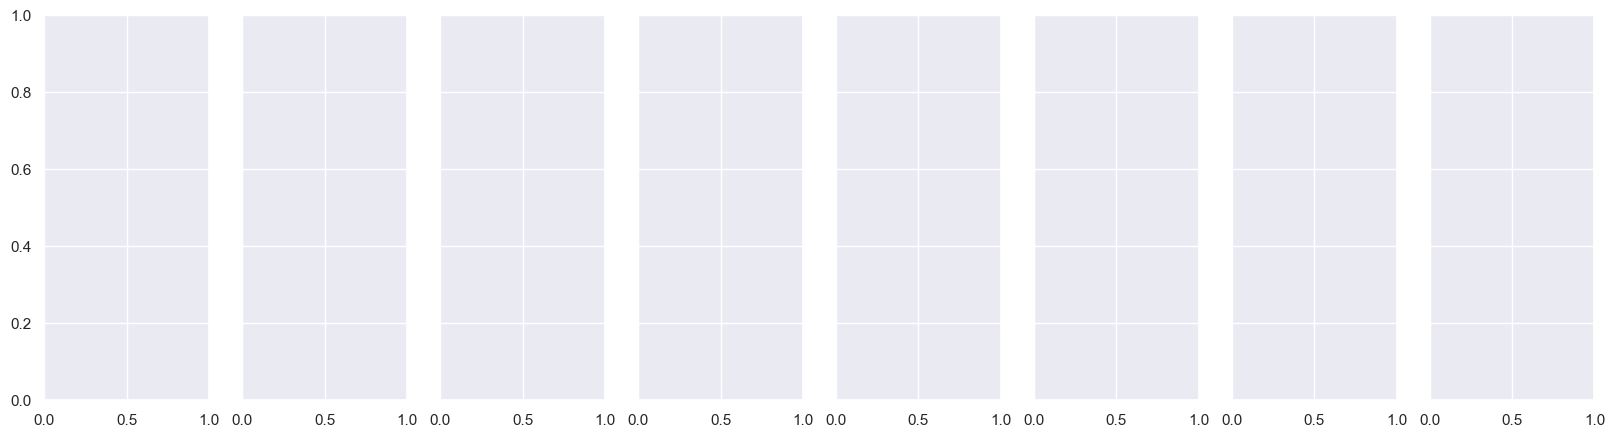

In [54]:
jsp =  dfs[0].reset_index(level=1, drop=True)
category = jsp.index.unique()
jsp.loc[category[0]]
fig, axes = plt.subplots(1, 8, figsize=(20, 5), sharex=True, sharey=True)

for idx, c in enumerate(category):
    for emotion in emotions:        
        sns.lineplot(
            jsp.loc[c][emotion],
            ax=ax,
            label=genre,
            color=palette[jdx]
        )
    plt.show()

In [ ]:

for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 8, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False

    for ax, emotion in zip(axes, emotions):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
        
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns)) 
        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

## using box office now

use the dataset without much cleaning to see if we can predict something with the data

In [36]:
# Group by 'Wikipedia_movie_ID' and calculate the mean of every emotion per film
df_boxoffice = interpolated_df.groupby('Wikipedia_movie_ID').mean()

# Merge with metadata to add movie-specific attributes such as category, box office revenue, runtime, and release date
df_boxoffice = df_boxoffice.merge(
    df_metadata[["Wikipedia_movie_ID", "category", "Movie_box_office_revenue", "Movie_runtime", "Movie_release_date", "continent"]],
    on="Wikipedia_movie_ID"
)

# Drop rows with any missing values to ensure only complete data rows are kept
df_boxoffice = df_boxoffice.dropna(axis=0)
df_boxoffice.sample(3)

Wikipedia_movie_ID     anger   disgust      fear       joy   neutral  \
2730               880056  0.087962  0.140188  0.100603  0.018595  0.398528   
1118               230481  0.175195  0.216052  0.188559  0.011022  0.312112   
20075            11448113  0.273045  0.117559  0.209790  0.025803  0.290560   

        sadness  surprise  timestep  \
2730   0.139978  0.114146       9.5   
1118   0.074077  0.022983       9.5   
20075  0.043932  0.039312       9.5   

                                         category  Movie_box_office_revenue  \
2730     [Others, Comedy, Fantasy/Sci-Fi, Horror]               220673217.0   
1118   [Action/Adventure, Fantasy/Sci-Fi, Horror]                98267558.0   
20075                                    [Comedy]                33526835.0   

       Movie_runtime  Movie_release_date      continent  
2730            84.0              2003.0  North America  
1118           108.0              1987.0  North America  
20075           88.0              2002.0  North America

In [37]:
#separate X and y for the train test split. 
#We keep category for y, so we can explose y_train and y_test after the split on the category
X = df_boxoffice.drop(columns=["Movie_box_office_revenue", 'Wikipedia_movie_ID', 'timestep'])
y = pd.DataFrame(df_boxoffice[["Movie_box_office_revenue", "category"]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) #test_size = 0.15 yiels better r2 score than .2
# One-hot encode the 'category' column in the training data to handle categorical genres
X_train = pd.get_dummies(X_train.explode('category'), columns=['category'])
X_train = pd.get_dummies(X_train, columns=['continent'])
# Only keep the boxoffice for y as it is the only thing that interest us here
y_train = pd.get_dummies(y_train.explode('category'), columns=['category'])['Movie_box_office_revenue']
X_test = pd.get_dummies(X_test.explode('category'), columns=['category'])
X_test = pd.get_dummies(X_test, columns=['continent'])
y_test = pd.get_dummies(y_test.explode('category'), columns=['category'])['Movie_box_office_revenue']
X_train = X_train[X_test.columns]

In [38]:
# Define a pipeline with two main steps: scaling and regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Step 1: Standardize features
    ("regressor", RandomForestRegressor(random_state=42))  # Step 2: Random Forest Regressor
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [39]:
#compute some metrics about the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)
mean_boxoffice = y_test.mean()
print(f"mean of boxoffice = {round(mean_boxoffice, 2)}")
std_boxoffice = y_test.std()
print(f"std of boxoffice = {round(std_boxoffice, 2)}")

Mean Absolute Error (MAE): 63389775.44092791
Mean Squared Error (MSE): 1.5782198158461472e+16
Root Mean Squared Error (RMSE): 125627219.01905443
R-squared (R²): -0.06624604362550834
mean of boxoffice = 62057161.79
std of boxoffice = 121684516.48


We can see that with a simple model, we cannot predict really well the boxoffice

Text(0.5, 0, 'Boxoffice revenue in dollars')

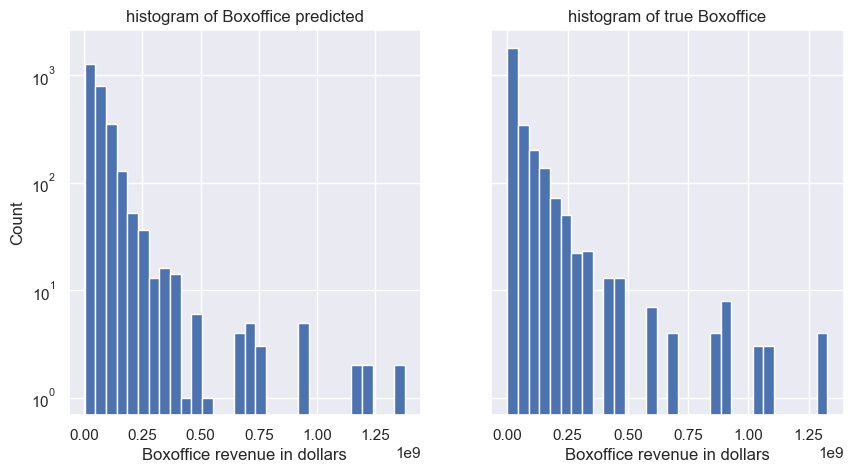

In [40]:
#plot the histogram of the prediction and the true value on a log scale
_, axes = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
axes = axes.ravel()
axes[0].hist(y_pred, bins=30)
axes[0].set_title('histogram of Boxoffice predicted')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Boxoffice revenue in dollars')
axes[0].set_yscale('log')
axes[1].hist(y_test,bins=30)
axes[1].set_title('histogram of true Boxoffice')
axes[1].set_xlabel('Boxoffice revenue in dollars')

### Plot the boxoffice of every genre for every continent


In [41]:
#As we care only about the boxoffice, and we have 20 timesteps/film, we take only 1 film every 20.
df_boxoffice = interpolated_df.iloc[::20].merge(df_metadata[["Wikipedia_movie_ID","category", "continent", "Movie_box_office_revenue"]], on="Wikipedia_movie_ID")
#drop every rows (movies) that does not have the box_office
df_boxoffice = df_boxoffice.dropna(subset=['Movie_box_office_revenue'], axis=0)[['category', 'continent', 'Movie_box_office_revenue']]
df_boxoffice = df_boxoffice.explode('category')
#compute the mean per category per continent
df_boxoffice_mean_by_category_and_genre = df_boxoffice.groupby(['category', 'continent']).mean()

In [42]:
df_boxoffice_mean_by_category_and_genre =df_boxoffice_mean_by_category_and_genre.reset_index()
continents = np.unique(df_boxoffice_mean_by_category_and_genre['continent'])

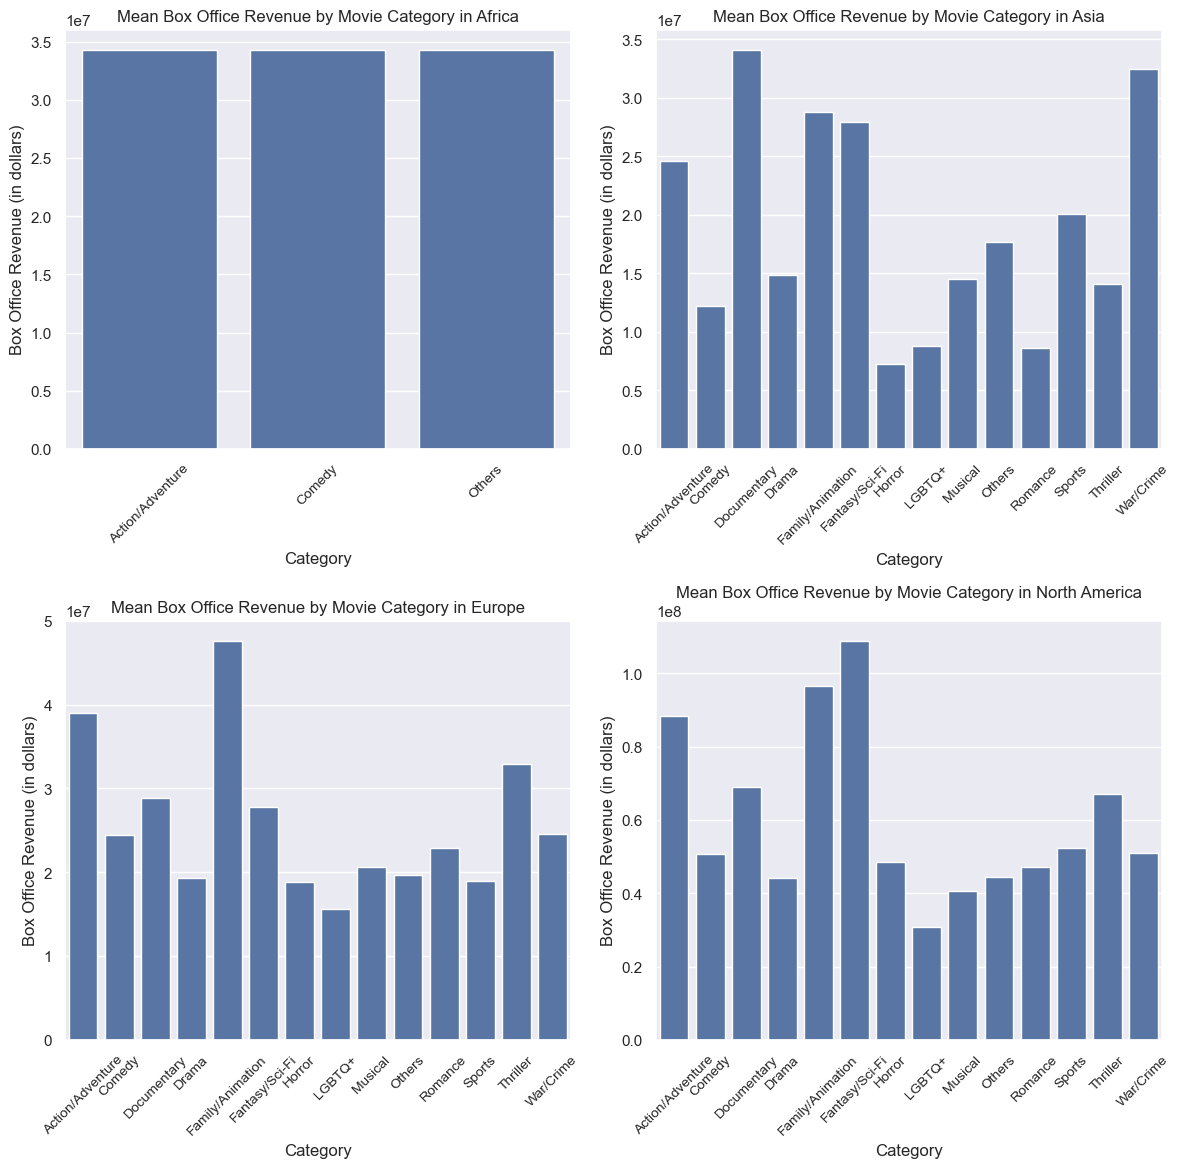

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for ax, continent in zip(axes, continents):
    df = df_boxoffice_mean_by_category_and_genre[df_boxoffice_mean_by_category_and_genre['continent'] == continent]
    sns.barplot(data=df, x="category", y="Movie_box_office_revenue", ax=ax)

    ax.set_title(f"Mean Box Office Revenue by Movie Category in {continent}")
    ax.set_xlabel("Category")
    ax.set_ylabel("Box Office Revenue (in dollars)")
    ax.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)
plt.tight_layout()